<a href="https://colab.research.google.com/github/sungulnara2000/DocumentDistortion/blob/main/DocumentDistortion_Current.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Установка библиотек

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.12 [154 kB]
Fetched 154 kB in 0s (891 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 155455 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.62.0-2ubuntu2.12_amd64.deb ...
Unpacking poppler-utils (0.62.0-2ubuntu2.12) ...
Setting up poppler-utils (0.62.0-2ubuntu2.12) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [44]:
!pip install python-poppler

     |████████████████████████████████| 823 kB 4.8 MB/s 
  ERROR: Failed building wheel for python-poppler
  Running setup.py clean for python-poppler
Failed to build python-poppler
    Running setup.py install for python-poppler ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-57xvd3_i/python-poppler_3b5840b57e644a18871bc10443cb2422/setup.py'"'"'; __file__='"'"'/tmp/pip-install-57xvd3_i/python-poppler_3b5840b57e644a18871bc10443cb2422/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-7nudb39a/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/python-poppler Check the

In [ ]:
!pip install opencv-contrib-python==3.4.2.17
!pip install -U plotly==4.12
!pip install pyheif Pillow
!pip install pdf2image
!apt-get install poppler-utils 

In [5]:
def sin(angle):
  return np.sin(np.deg2rad(angle))

def cos(angle):
  return np.cos(np.deg2rad(angle))

def rint(x):
  ret = np.rint(x).astype(int)
  if type(x) == tuple:
    ret = tuple(ret)
  return ret

def int_tuple(l):
  return tuple(map(int, l))

def nearest_odd(x):
    return int(np.ceil(x) // 2 * 2 + 1)


def reduce_in_size(image, n):
  return cv.resize(image, (rint(image.shape[1] / n), rint(image.shape[0] / n)))

In [73]:
import numpy as np
import cv2 as cv
import os
from os import path
from google.colab.patches import cv2_imshow
from scipy.spatial import distance
from PIL import Image
import pyheif
import glob
from scipy.optimize import brentq
from tqdm import tqdm

from scipy import interpolate

import pdf2image

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
def conv_heic2png(image_path, delete=False):
    new_name = image_path.replace('HEIC', 'png')
    heif_file = pyheif.read(image_path)
    data = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,
        "raw",
        heif_file.mode,
        heif_file.stride,
        )
    data.save(new_name, "PNG")
    if delete:
      os.remove(image_path)

def heic2png(path, delete=False):
  lst = glob.glob(f"{path}/*.HEIC")
  for l in lst:
      conv_heic2png(l, delete)

In [72]:
SAMPLES_FOLDER = '/content/drive/MyDrive/paper_distortions'
RESULTS_FOLDER = os.path.join(SAMPLES_FOLDER, 'results')
CRUMPLED_RESULTS_FOLDER = os.path.join(SAMPLES_FOLDER, 'crumpled_results')
EDOCS_FOLDER = os.path.join(SAMPLES_FOLDER, 'electronic_documents')
EDOCS_PDF_FOLDER = os.path.join(SAMPLES_FOLDER, 'pdfs')

PDF_DPI = 400

N_DOTS_ROW = 21
N_DOTS_COL = 30

In [ ]:
heic2png(SAMPLES_FOLDER, delete=True)

In [71]:
# !rm $EDOCS_FOLDER/*

In [74]:
pdfs = os.listdir(EDOCS_PDF_FOLDER)
for filename in pdfs:
  basename = filename.split('.')[0]
  pdf2image.convert_from_path(os.path.join(EDOCS_PDF_FOLDER, filename), 
                              dpi=PDF_DPI, 
                              output_folder=EDOCS_FOLDER,
                              fmt='png',
                              output_file=f'{basename}_dpi_{PDF_DPI}')

# Детекция точек

In [14]:
CIRCLE_N = 32
reference_circle = np.ones((CIRCLE_N, CIRCLE_N), np.uint8) * 255
reference_circle = cv.circle(reference_circle, 
                             rint((CIRCLE_N/2, CIRCLE_N/2)), 
                             rint(CIRCLE_N/5), 
                             color=(0, 0, 0), 
                             thickness=-1)

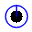

In [15]:
surf = cv.xfeatures2d.SURF_create(hessianThreshold=700, nOctaves=2, nOctaveLayers=2, upright=True)
reference_circle_kp, reference_circle_des = surf.detectAndCompute(reference_circle, None)
img_surf = cv.drawKeypoints(reference_circle, reference_circle_kp, None,(255,0,0),4)
cv2_imshow(img_surf)

In [16]:
def intersection_area(d, R, r):
    """Return the area of intersection of two circles.

    The circles have radii R and r, and their centres are separated by d.

    """

    if d <= abs(R-r):
        # One circle is entirely enclosed in the other.
        return np.pi * min(R, r)**2
    if d >= r + R:
        # The circles don't overlap at all.
        return 0

    r2, R2, d2 = r**2, R**2, d**2
    alpha = np.arccos((d2 + r2 - R2) / (2*d*r))
    beta = np.arccos((d2 + R2 - r2) / (2*d*R))
    return ( r2 * alpha + R2 * beta -
             0.5 * (r2 * np.sin(2*alpha) + R2 * np.sin(2*beta))
           )

In [17]:
def iou_key_points(kp_one, kp_two):
  distance_between_centers = np.linalg.norm(np.array(kp_one.pt) - np.array(kp_two.pt))
  intersection = intersection_area(distance_between_centers, kp_one.size, kp_two.size)
  area_one = np.pi * kp_one.size ** 2
  area_two = np.pi * kp_two.size ** 2
  return intersection / (area_one + area_two - intersection)

def delete_similar_key_points(kp, iou_threshold):
  """
  Note that kp should be passed in descending response order (as from detectAndCompute)
  """
  assert sorted(kp, key=lambda x: -x.response) == kp

  new_kp = []
  indices = []

  for i, point in enumerate(kp):
    discard = False
    for compare_point in kp:
      if iou_key_points(point, compare_point) >= iou_threshold:
        if compare_point.response > point.response:
          discard = True
    if not discard:
      new_kp.append(point)
      indices.append(i)

  return new_kp, indices

In [ ]:
img = cv.imread(path.join(SAMPLES_FOLDER, 'IMG_1436.png'))
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

surf = cv.xfeatures2d.SURF_create(hessianThreshold=1500, upright=True)

img_blur = cv.GaussianBlur(img, (15, 15), 0)

# cv2_imshow(img_blur)
kp, des = surf.detectAndCompute(img_blur, None)

print(kp[0].pt)

img_surf = cv.drawKeypoints(img, kp, None,(255,0,0), 4)
# cv2_imshow(cv.resize(img_surf, (rint(img_surf.shape[1] / 2), rint(img_surf.shape[0] / 2))))

(2189.21533203125, 2634.302978515625)


In [ ]:
new_kp, indices = delete_similar_key_points(kp, iou_threshold=0.2)

In [ ]:
len(kp), len(new_kp)

(1412, 692)

In [ ]:
new_des = des[indices]

In [ ]:
img_surf = cv.drawKeypoints(img, new_kp, None,(255,0,0), 4)
cv2_imshow(cv.resize(img_surf, (rint(img_surf.shape[1] / 2), rint(img_surf.shape[0] / 2))))

In [ ]:
circle_kp = sorted(list(zip(new_kp, new_des)), key=lambda x: np.linalg.norm(x[1] - reference_circle_des))
circle_kp = [x[0] for x in circle_kp]

In [ ]:
img_surf = cv.drawKeypoints(img, circle_kp[:N_DOTS_ROW * N_DOTS_COL], None, (255, 0, 0), 4)
cv2_imshow(cv.resize(img_surf, (rint(img_surf.shape[1] / 2), rint(img_surf.shape[0] / 2))))

In [ ]:
img = cv.imread(path.join(SAMPLES_FOLDER, 'IMG_1443.png'))

# convert img to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# blur image
blur = cv.GaussianBlur(gray, (9,9), 0)

# do otsu threshold on gray image
thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 77, 33)
# thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)[1]

# apply morphology
kernel = np.ones((7,7), np.uint8)
morph = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
# kernel = np.ones((9,9), np.uint8)
morph = cv.morphologyEx(morph, cv.MORPH_OPEN, kernel)

# cv2_imshow(blur)
cv2_imshow(thresh)
cv2_imshow(morph)

# get largest contour
contours = cv.findContours(morph, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key = cv.contourArea)

countour_img = cv.drawContours(img, [big_contour], 0, (0,255,0), 3)
# cv2_imshow(countour_img)

In [ ]:
img = cv.imread(path.join(SAMPLES_FOLDER, 'IMG_1435.png'))

# convert img to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# blur image
blur = cv.GaussianBlur(gray, (9,9), 0)

# do otsu threshold on gray image
thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 77, 33)
# thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)[1]

# apply morphology
kernel = np.ones((7,7), np.uint8)
morph = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
morph = cv.morphologyEx(morph, cv.MORPH_OPEN, kernel)

# cv2_imshow(blur)
cv2_imshow(thresh)
cv2_imshow(morph)

# get largest contour
contours = cv.findContours(morph, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key = cv.contourArea)

countour_img = cv.drawContours(img, [big_contour], 0, (0,255,0), 3)
# cv2_imshow(countour_img)

In [ ]:
img = cv.imread(path.join(SAMPLES_FOLDER, 'IMG_1435.png'))

# convert img to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# blur image
blur = cv.GaussianBlur(gray, (9,9), 0)

# do otsu threshold on gray image
thresh = cv.adaptiveThreshold(blur,255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, nearest_odd(blur.shape[0] / 100), 5)
# thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)[1]

# apply morphology
kernel = np.ones((7,7), np.uint8)
morph = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
morph = cv.morphologyEx(morph, cv.MORPH_OPEN, kernel)

# cv2_imshow(blur)
cv2_imshow(thresh)
cv2_imshow(morph)

# get largest contour
contours = cv.findContours(morph, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key = cv.contourArea)

countour_img = cv.drawContours(img, [big_contour], 0, (0,255,0), 3)
# cv2_imshow(countour_img)

In [ ]:
nearest_odd(blur.shape[0] / 200)

21

In [ ]:
img = cv.imread(path.join(SAMPLES_FOLDER, 'IMG_1435.png'))

# convert img to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# blur image
blur = cv.GaussianBlur(gray, (11,11), 0)

# do otsu threshold on gray image
thresh = cv.adaptiveThreshold(blur,255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 41, 5)

# apply morphology
kernel = np.ones((7,7), np.uint8)
morph = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
kernel = np.ones((7, 7), np.uint8)
morph = cv.morphologyEx(morph, cv.MORPH_OPEN, kernel)

cv2_imshow(blur)
cv2_imshow(thresh)
cv2_imshow(morph)

# get largest contour
contours = cv.findContours(morph, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key = cv.contourArea)

countour_img = cv.drawContours(img, [big_contour], 0, (0,255,0), 3)
# cv2_imshow(countour_img)

In [ ]:
cv.pointPolygonTest(big_contour, (2000, 2000), measureDist=False), cv.pointPolygonTest(big_contour, (2000, 2000), measureDist=True)

(1.0, 550.9863882166237)

In [ ]:
cv.pointPolygonTest(big_contour, (0, 0), measureDist=False), cv.pointPolygonTest(big_contour, (0, 0), measureDist=True)

(-1.0, -477.3782567314938)

In [ ]:
!ls $SAMPLES_FOLDER

6a2e56bf-11e1-4cd0-aef1-3d628d49c458-2.jpg  IMG_1446.png
alined.jpg				    IMG_1447.png
electronic_documents			    IMG_1449.png
IMG_1435.png				    IMG-20211130-WA0067-2.jpg
IMG_1436.png				    IMG-20211130-WA0067.jpg
IMG_1438.png				    IMG-20211130-WA0069-2.jpg
IMG_1439.png				    IMG-20211130-WA0069.jpg
IMG_1441.png				    photo_2021-12-26_19-00-26.jpg
IMG_1442.png				    qXYn5.jpg
IMG_1443.png				    red_blue_dots_a4_2480_3508.png
IMG_1445.png


In [ ]:
surf = cv.xfeatures2d.SIFT_create(hessianThreshold=700, nOctaves=2, nOctaveLayers=2, upright=True)

img_blur = cv.GaussianBlur(img, (15, 15), 0)
cv2_imshow(img_blur)
kp, des = surf.detectAndCompute(img_blur, None)

# Удаление маркеров

In [ ]:
img = cv.imread(path.join(SAMPLES_FOLDER, 'IMG_1436.png'))

# convert img to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# blur image
blur = cv.GaussianBlur(gray, (9,9), 0)

# do otsu threshold on gray image
thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 77, 33)
# thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)[1]

# apply morphology
kernel = np.ones((7,7), np.uint8)
morph = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
morph = cv.morphologyEx(morph, cv.MORPH_OPEN, kernel)

cv2_imshow(morph)

In [ ]:
countour_img = cv.drawContours(img, contours, -1, (0,255,0), 3)
cv2_imshow(countour_img)

In [ ]:
cv2_imshow(morph)

In [ ]:
contours = cv.findContours(morph, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

In [ ]:
len(contours[1])

1

In [ ]:
big_contour = max(contours[1], key = cv.contourArea)

In [ ]:
img = cv.imread(path.join(SAMPLES_FOLDER, 'IMG_1442.png'))
contour_image = cv.drawContours(img, [big_contour], 0, (0,255,0), 3)
cv2_imshow(cv.resize(contour_image, (1512, 2016)))

In [ ]:
cv2_imshow(cv.drawContours(img, contours[1], -1, (0,255,0), 3))

In [ ]:
img = cv.imread(path.join(SAMPLES_FOLDER, 'IMG_1442.png'))


# convert img to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# blur image
blur = cv.GaussianBlur(gray, (9,9), 0)

# do otsu threshold on gray image
# thresh = cv.adaptiveThreshold(blur,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, nearest_odd(blur.shape[0] / 100), 5)
thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)[1]

# apply morphology
kernel = np.ones((7,7), np.uint8)
thresh = thresh
morph = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
morph = cv.morphologyEx(morph, cv.MORPH_OPEN, kernel)
# kernel = np.ones((3,3), np.uint8)
# morph = cv.erode(morph, kernel, iterations=1)

# cv2_imshow(blur)
# cv2_imshow(thresh)
# cv2_imshow(morph)

# get largest contour
contours = cv.findContours(morph, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key = cv.contourArea)

countour_img = cv.drawContours(img, [big_contour], 0, (0,255,0), 3)
# cv2_imshow(countour_img)

In [ ]:
img = cv.imread(path.join(SAMPLES_FOLDER, 'IMG_1442.png'))


# convert img to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# blur image
blur = cv.GaussianBlur(gray, (9,9), 0)

# do otsu threshold on gray image
thresh = cv.adaptiveThreshold(blur,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, nearest_odd(blur.shape[0] / 100), 5)

# apply morphology
kernel = np.ones((7,7), np.uint8)
morph = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
morph = cv.morphologyEx(morph, cv.MORPH_OPEN, kernel)

# cv2_imshow(blur)
# cv2_imshow(thresh)
# cv2_imshow(morph)

# get largest contour
contours = cv.findContours(morph, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key = cv.contourArea)

countour_img = cv.drawContours(img, [big_contour], 0, (0,255,0), 3)
cv2_imshow(countour_img)

In [ ]:
img = cv.imread(path.join(SAMPLES_FOLDER, 'IMG_1436.png'))


# convert img to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# blur image
blur = cv.GaussianBlur(gray, (9,9), 0)

# do otsu threshold on gray image
thresh = cv.adaptiveThreshold(blur,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, nearest_odd(blur.shape[0] / 100), 5)

# apply morphology
kernel = np.ones((7,7), np.uint8)
morph = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
morph = cv.morphologyEx(morph, cv.MORPH_OPEN, kernel)

# cv2_imshow(blur)
# cv2_imshow(thresh)
cv2_imshow(morph)

# get largest contour
contours = cv.findContours(morph, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key = cv.contourArea)

countour_img = cv.drawContours(img, [big_contour], 0, (0,255,0), 3)
cv2_imshow(countour_img)

In [ ]:
# do otsu threshold on gray image
thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, nearest_odd(blur.shape[0] / 100), 5)

# apply morphology
kernel = np.ones((7,7), np.uint8)
morph = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
morph = cv.morphologyEx(morph, cv.MORPH_OPEN, kernel)

# cv2_imshow(blur)
# cv2_imshow(thresh)
# cv2_imshow(morph)

# get largest contour
image, contours, hierarchy = cv.findContours(morph, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# contours = contours[0] if len(contours) == 2 else contours[1]
# big_contour = max(contours, key = cv.contourArea)

# countour_img = cv.drawContours(img, contours, 0, (0,255,0), 3)
# cv2_imshow(countour_img)

In [ ]:
cv2_imshow(morph)

In [ ]:
cv2_imshow(countour_img)

In [ ]:
kernel = np.ones((7,7), np.uint8)
dilated = cv.dilate(255 - morph, kernel, iterations=1)
cv2_imshow(dilated)

In [ ]:
dst = cv.inpaint(img, dilated, 30, cv.INPAINT_TELEA)
cv2_imshow(dst)

In [ ]:
dst = cv.inpaint(img, dilated, 3, cv.INPAINT_TELEA)
cv2_imshow(dst)

In [ ]:
dst = cv.inpaint(img, dilated, 3, cv.INPAINT_NS)
cv2_imshow(dst)

# Сохранение результатов

Протестированы:  
<!-- IMG_1436   -->
IMG_1446  
IMG_3256  
3267

In [221]:
!ls $SAMPLES_FOLDER

 6a2e56bf-11e1-4cd0-aef1-3d628d49c458-2.jpg   IMG_3253.png
 alined.jpg				      IMG_3254.png
 electronic_documents			      IMG_3255.png
 IMG_1435.png				      IMG_3256.png
 IMG_1436.png				      IMG_3257.png
 IMG_1438.png				      IMG_3258.png
 IMG_1439.png				      IMG_3259.png
 IMG_1441.png				      IMG_3260.png
 IMG_1442.png				      IMG_3261.png
 IMG_1443.png				      IMG_3262.png
 IMG_1445.png				      IMG_3263.png
 IMG_1446.png				      IMG_3264.png
 IMG_1447.jpg				      IMG_3265.png
 IMG_1447.png				      IMG_3266.png
 IMG_1449.png				      IMG_3267.png
 IMG-20211130-WA0067-2.jpg		      IMG_3268.png
 IMG-20211130-WA0067.jpg		      IMG_3269.png
 IMG-20211130-WA0069-2.jpg		      IMG_3270.png
 IMG-20211130-WA0069.jpg		      IMG_3271.png
 IMG_3248.png				      photo_2021-12-26_19-00-26.jpg
 IMG_3249.png				      qXYn5.jpg
 IMG_3250.png				      red_blue_dots_a4_2480_3508.png
 IMG_3251.png				      results
 IMG_3252.png				     'Копия IMG_1447.jpg'


In [307]:
print(*[x for x in os.listdir(RESULTS_FOLDER) if 'transformed_shadows_' in x], end="' '", sep="' '")

transformed_shadows_mult_IMG_3267_Diagram description (2)_page-0001.png' 'transformed_shadows_alpha_IMG_3267_Diagram description (2)_page-0001.png' 'transformed_shadows_alpha_IMG_1443_Article Multisensory marketing (senses)_page-0001.png' 'transformed_shadows_mult_IMG_1443_Article Multisensory marketing (senses)_page-0001.png' 'transformed_shadows_alpha_IMG_1446_pervichnye_dokumenty_buhgalterskogo_ucheta_3.png' 'transformed_shadows_mult_IMG_1446_pervichnye_dokumenty_buhgalterskogo_ucheta_3.png' 'transformed_shadows_alpha_IMG_1446_Article Multisensory marketing (senses)_page-0001.png' 'transformed_shadows_mult_IMG_1446_Article Multisensory marketing (senses)_page-0001.png' 'transformed_shadows_alpha_IMG_3264_Article Multisensory marketing (senses)_page-0002.png' 'transformed_shadows_mult_IMG_3264_Article Multisensory marketing (senses)_page-0002.png' 'transformed_shadows_alpha_IMG_3266_report_finance.png' 'transformed_shadows_mult_IMG_3266_report_finance.png' '

In [314]:
!ls

drive  sample_data


In [313]:
# os.chdir('RESULTS_FOLDER')

In [308]:
! cp 'transformed_shadows_mult_IMG_3267_Diagram description (2)_page-0001.png' 'transformed_shadows_alpha_IMG_3267_Diagram description (2)_page-0001.png' 'transformed_shadows_alpha_IMG_1443_Article Multisensory marketing (senses)_page-0001.png' 'transformed_shadows_mult_IMG_1443_Article Multisensory marketing (senses)_page-0001.png' 'transformed_shadows_alpha_IMG_1446_pervichnye_dokumenty_buhgalterskogo_ucheta_3.png' 'transformed_shadows_mult_IMG_1446_pervichnye_dokumenty_buhgalterskogo_ucheta_3.png' 'transformed_shadows_alpha_IMG_1446_Article Multisensory marketing (senses)_page-0001.png' 'transformed_shadows_mult_IMG_1446_Article Multisensory marketing (senses)_page-0001.png' 'transformed_shadows_alpha_IMG_3264_Article Multisensory marketing (senses)_page-0002.png' 'transformed_shadows_mult_IMG_3264_Article Multisensory marketing (senses)_page-0002.png' 'transformed_shadows_alpha_IMG_3266_report_finance.png' 'transformed_shadows_mult_IMG_3266_report_finance.png' ../crumpled_results/

# Нумерация 2

In [10]:
FILENAME = 'IMG_1443.png'
FILEBASENAME = FILENAME.split('.')[0]

In [11]:
img = cv.imread(path.join(SAMPLES_FOLDER, FILENAME))

if img.shape[0] < img.shape[1]:
  img = cv.rotate(img, cv.cv2.ROTATE_90_CLOCKWISE)
  cv.imwrite(path.join(SAMPLES_FOLDER, FILENAME), img)

img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_blur = cv.GaussianBlur(img_gray, (15, 15), 0)

In [ ]:
surf = cv.xfeatures2d.SURF_create(hessianThreshold=1500, upright=True)
kp, des = surf.detectAndCompute(img_blur, None)

new_kp, indices = delete_similar_key_points(kp, iou_threshold=0.2)
new_des = des[indices]

circle_kp_des = sorted(list(zip(new_kp, new_des)), key=lambda x: np.linalg.norm(x[1] - reference_circle_des))
circle_kp = [x[0] for x in circle_kp_des][:N_DOTS_ROW * N_DOTS_COL]
circle_des = [x[1] for x in circle_kp_des][:N_DOTS_ROW * N_DOTS_COL]

img_surf = cv.drawKeypoints(img, circle_kp, None, (255, 0, 0), 4)
cv2_imshow(reduce_in_size(img_surf, 4))

cv.imwrite(f'{RESULTS_FOLDER}/detected_{FILEBASENAME}.png', img_surf)

In [ ]:
# thresh = cv.adaptiveThreshold(img_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 77, -10)
thresh = cv.threshold(img_blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)[1]

kernel = np.ones((7,7), np.uint8)
morph = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
morph = cv.morphologyEx(morph, cv.MORPH_OPEN, kernel)

contours = cv.findContours(morph, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv.contourArea)

countour_img = img.copy()
countour_img = cv.drawContours(countour_img, [big_contour], 0, (0,255,0), 3)
cv2_imshow(reduce_in_size(countour_img, 4))

# cv.imwrite(f'{RESULTS_FOLDER}/countour_{FILEBASENAME}.png', countour_img)

In [23]:
# border_points = sorted(circle_kp, key=lambda x: cv.pointPolygonTest(big_contour, x.pt, True))

# img_surf = img_gray.copy()
# img_surf = cv.drawKeypoints(img_surf, border_points[:N_DOTS_ROW * 2 + N_DOTS_COL * 2 - 4], None, (0, 0, 255), 4)
# cv2_imshow(cv.resize(img_surf, (rint(img_surf.shape[1] / 3), 
#                                 rint(img_surf.shape[0] / 3))))

# border_points = set(border_points[:N_DOTS_ROW * 2 + N_DOTS_COL * 2 - 4])

In [ ]:
# get perimeter and approximate a polygon
peri = cv.arcLength(big_contour, True)
corners = cv.approxPolyDP(big_contour, 0.04 * peri, True)

# draw polygon on input image from detected corners
polygon = img.copy()
cv.polylines(polygon, [corners], True, (0,0,255), 1, cv.LINE_AA)
# Alternate: cv.drawContours(page,[corners],0,(0,0,255),1)

corners = corners.squeeze()

# They seem to be listed counter-clockwise from the top most corner
# renumerate so that the left top is the first
if np.linalg.norm(corners[0] - corners[1]) < np.linalg.norm(corners[2] - corners[1]):
  corners = np.roll(corners, -1, axis=0)

assert len(corners) == 4

for i in range(4):
  polygon = cv.putText(
      polygon, 
      str(i), 
      tuple(rint(corners[i])), 
      cv.FONT_HERSHEY_SIMPLEX, 
      5,
      (0, 255, 0), 
      3, 
      cv.LINE_AA)

cv2_imshow(reduce_in_size(polygon, 4))
cv.imwrite(f'{RESULTS_FOLDER}/polygon_{FILEBASENAME}.png', polygon)

* Первая точка левая верхняя
* Если находимся в начале строки, то запоминаем где начинается следующая строка
* Если находимся в конце строки, то переходим на начало строки
* В других случаях находим следующую справа точку в строку и переходим в нее

In [25]:
top_left_point = min(circle_kp, 
                     key=lambda x: 
                     np.linalg.norm(np.array(x.pt) - corners[0]))

ordered_kp = np.empty((N_DOTS_COL, N_DOTS_ROW), dtype=cv.KeyPoint)
ordered_kp[0][0] = top_left_point
unvisited_kp = set(circle_kp)
unvisited_kp.remove(top_left_point)


img_ordered_markers = img.copy()


for row in range(N_DOTS_COL):
  for col in range(N_DOTS_ROW - 1):
    current_point = ordered_kp[row][col]

    if row == N_DOTS_COL - 1:
      consider_n_neighbours = 1
    elif col == 0 or col == 1:
      consider_n_neighbours = 3
    else:
      consider_n_neighbours = 4

    neighbours = sorted(unvisited_kp,
                  key=lambda x: 
                  np.linalg.norm(
                      np.array(x.pt) - np.array(current_point.pt))
                  )[:consider_n_neighbours]

    if col == 0 and row < N_DOTS_COL - 1:
      ordered_kp[row + 1][0] = min(neighbours, 
                                    key=lambda x: (x.pt[0], -x.pt[1]))
      unvisited_kp.remove(ordered_kp[row + 1][0])

      img_ordered_markers = cv.arrowedLine(img_ordered_markers, 
                          rint(current_point.pt), 
                          rint(ordered_kp[row + 1][0].pt),
                          (0, 0, 0), 2)
      
    
    ordered_kp[row][col + 1] = min(neighbours, 
                                key=lambda x: (x.pt[1], -x.pt[0]))
    unvisited_kp.remove(ordered_kp[row][col + 1])

    img_ordered_markers = cv.arrowedLine(img_ordered_markers, 
                          rint(current_point.pt), 
                          rint(ordered_kp[row][col + 1].pt),
                          (0, 0, 0), 2)

for row in range(N_DOTS_COL):
  for col in range(N_DOTS_ROW):
      cv.putText(
        img_ordered_markers, 
        f'{col}',
        rint(ordered_kp[row][col].pt), 
        cv.FONT_HERSHEY_SIMPLEX, 
        1,
        (255, 0, 0), 
        2,
        cv.LINE_AA)

In [ ]:
cv2_imshow(reduce_in_size(img_ordered_markers, 4))
cv.imwrite(f'{RESULTS_FOLDER}/ordered_{FILEBASENAME}.png', img_ordered_markers)

# Удаление маркеров 2

In [27]:
mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
for kp in circle_kp:
  mask = cv.circle(mask, rint(kp.pt), rint(kp.size / 2), (255, 255, 255), -1)

In [ ]:
cv2_imshow(reduce_in_size(mask, 4))

In [ ]:
inpainted = cv.inpaint(img, mask, 3, cv.INPAINT_TELEA)

cv2_imshow(reduce_in_size(inpainted, 4))
cv.imwrite(f'{RESULTS_FOLDER}/inpainted_{FILEBASENAME}.png', inpainted)

# Смятие документа 2

In [75]:
EDOCFILE = 'Article Multisensory marketing (senses)0001-1.png'
EDOCBASENAME = EDOCFILE.split('.')[0]

In [76]:
edoc = cv.imread(path.join(SAMPLES_FOLDER, 'electronic_documents', EDOCFILE))

In [77]:
edoc_height, edoc_width = edoc.shape[:2]
photo_height, photo_width = img.shape[:2]

In [79]:
crumpled_grid = np.array(list(map(
    lambda point_list: 
    np.array([point.pt for point in point_list]), 
    ordered_kp)))

crumpled_grid[:, :, 1] *= edoc_height / photo_height
crumpled_grid[:, :, 0] *= edoc_width / photo_width

In [80]:
y_grid = np.linspace(0, edoc_height, N_DOTS_COL)
x_grid = np.linspace(0, edoc_width, N_DOTS_ROW)

In [81]:
# TODO: generate pairs faster!

points = np.array([[x, y] for x in range(edoc_width) for y in range(edoc_height)])

init_dot_positions = np.array([[x, y] for y in y_grid for x in x_grid])

transformed_dot_positions =  crumpled_grid.reshape((-1, 2))

In [82]:
interpolated = interpolate.griddata(init_dot_positions, transformed_dot_positions, points, method='linear')

In [83]:
transformed_edoc = np.full((edoc_height, edoc_width, 3), 255, dtype=np.uint8)

%timeit
operated = 0
for i in tqdm(range(len(points))):
  if not np.isnan(interpolated[i]).any():
    operated += 1
    y = max(0, int(np.round(interpolated[i][1])))
    y = min(y, edoc_height - 1)

    x = max(0, int(np.round(interpolated[i][0])))
    x = min(x, edoc_width - 1)
    transformed_edoc[y, x, :] = edoc[points[i][1], points[i][0], :]

print(operated)

100%|██████████| 15493536/15493536 [07:27<00:00, 34593.24it/s]

15493536


In [ ]:
cv2_imshow(reduce_in_size(transformed_edoc, 2))
cv.imwrite(f'{RESULTS_FOLDER}/transformed_{FILEBASENAME}_{EDOCBASENAME}_dpi_{PDF_DPI}.png', transformed_edoc)

# Наложение освещения

In [85]:
paper_contour = np.zeros(inpainted.shape)
paper_contour = cv.drawContours(paper_contour, [big_contour], 0, (1, 1, 1), -1)

In [86]:
illumination = inpainted * paper_contour
illumination = cv.resize(illumination, (edoc_width, edoc_height))

In [87]:
alpha = 0.6
transformed_edoc_shadows = illumination * (1 - alpha) + transformed_edoc * alpha

In [ ]:
cv2_imshow(reduce_in_size(transformed_edoc_shadows, 2))
cv.imwrite(f'{RESULTS_FOLDER}/transformed_shadows_alpha_{FILEBASENAME}_dpi_{PDF_DPI}_{EDOCBASENAME}.png', transformed_edoc_shadows)

In [89]:
illumination_normalized = cv.normalize(illumination, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
transformed_edoc_shadows_mult = illumination_normalized * transformed_edoc

In [ ]:
cv2_imshow(reduce_in_size(transformed_edoc_shadows_mult, 2))
cv.imwrite(f'{RESULTS_FOLDER}/transformed_shadows_mult_{FILEBASENAME}_dpi_{PDF_DPI}_{EDOCBASENAME}.png', transformed_edoc_shadows_mult)

# Результаты

In [ ]:
h, w = rint(np.array(edoc.shape[:2]) * 0.8)

img_surf_res = cv.resize(img_surf, (w, h))
img_ordered_markers_res = cv.resize(img_ordered_markers, (w, h))
inpainted_res = cv.resize(inpainted, (w, h))

edoc_res = cv.resize(edoc, (w, h))
transformed_edoc_res = cv.resize(transformed_edoc, (w, h))
transformed_edoc_shadows_res = cv.resize(transformed_edoc_shadows, (w, h))

In [ ]:
inpaint_res_stacked = np.hstack((img_surf_res, img_ordered_markers_res, inpainted_res))

In [ ]:
cv2_imshow(inpaint_res_stacked)

In [ ]:
transformation_res_stacked = np.hstack((edoc_res, transformed_edoc_res, transformed_edoc_shadows_res))

In [ ]:
cv2_imshow(transformation_res_stacked)

In [ ]:
cv2_imshow(transformed_edoc_shadows_res)

In [ ]:
vstacked = np.vstack((inpaint_res_stacked, transformation_res_stacked))

In [ ]:
cv2_imshow(vstacked)

# Нахождение границы листа